<a href="https://www.kaggle.com/code/eduardotvn/alzheimer-s-analysis-and-prediction?scriptVersionId=184944231" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-22 20:36:18.629276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 20:36:18.629435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 20:36:18.812323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv


In [2]:
dataset = pd.read_csv('/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

This dataset is ready to go. It has no null values and the only object column is not used for classification, and it's values are 'anonymous', so we can drop it later. Let's take a look on a head.

In [4]:
dataset.head()

PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4           18.454356          6.310461     0.795498  ...                 0   

   BehavioralProblems       ADL  Confusion  Disorientation  \
0                   0  1.725883          0               0   
1                   0  2.592424          0               0   
2                   0  7.119548          0               1   
3                   1  6.481226          0               0   
4                   0  0.014691          0               0   

   PersonalityChanges  DifficultyCompletingTasks  Forgetfulness  Diagnosis  \
0                   0                          1              0          0   
1                   0                          0              1          0   
2                   0                          1              0          0   
3                   0                          0              0          0   
4                   1                          1              0          0   

   DoctorInCharge  
0       XXXConfid  
1       XXXConfid  
2       XXXConfid  
3       XXXConfid  
4       XXXConfid  

[5 rows x 35 columns]

In our dataset, we have a total of 35 columns. As described in the main page:
0 : PatientID is self describing.
1 - 4 : Stands for patient information
5 - 10: Stands for lifestyle factors
11 - 16: Medical History
17 - 22: Clinical Meaurements
23 - 27: Cognitive and Mental Assesments
28 - 32: Symptoms
33: Diagnosis
34: DoctorInformation

In [5]:
dataset.describe()

PatientID          Age       Gender    Ethnicity  EducationLevel  \
count  2149.000000  2149.000000  2149.000000  2149.000000     2149.000000   
mean   5825.000000    74.908795     0.506282     0.697534        1.286645   
std     620.507185     8.990221     0.500077     0.996128        0.904527   
min    4751.000000    60.000000     0.000000     0.000000        0.000000   
25%    5288.000000    67.000000     0.000000     0.000000        1.000000   
50%    5825.000000    75.000000     1.000000     0.000000        1.000000   
75%    6362.000000    83.000000     1.000000     1.000000        2.000000   
max    6899.000000    90.000000     1.000000     3.000000        3.000000   

               BMI      Smoking  AlcoholConsumption  PhysicalActivity  \
count  2149.000000  2149.000000         2149.000000       2149.000000   
mean     27.655697     0.288506           10.039442          4.920202   
std       7.217438     0.453173            5.757910          2.857191   
min      15.008851     0.000000            0.002003          0.003616   
25%      21.611408     0.000000            5.139810          2.570626   
50%      27.823924     0.000000            9.934412          4.766424   
75%      33.869778     1.000000           15.157931          7.427899   
max      39.992767     1.000000           19.989293          9.987429   

       DietQuality  ...  FunctionalAssessment  MemoryComplaints  \
count  2149.000000  ...           2149.000000       2149.000000   
mean      4.993138  ...              5.080055          0.208004   
std       2.909055  ...              2.892743          0.405974   
min       0.009385  ...              0.000460          0.000000   
25%       2.458455  ...              2.566281          0.000000   
50%       5.076087  ...              5.094439          0.000000   
75%       7.558625  ...              7.546981          0.000000   
max       9.998346  ...              9.996467          1.000000   

       BehavioralProblems          ADL    Confusion  Disorientation  \
count         2149.000000  2149.000000  2149.000000     2149.000000   
mean             0.156817     4.982958     0.205212        0.158213   
std              0.363713     2.949775     0.403950        0.365026   
min              0.000000     0.001288     0.000000        0.000000   
25%              0.000000     2.342836     0.000000        0.000000   
50%              0.000000     5.038973     0.000000        0.000000   
75%              0.000000     7.581490     0.000000        0.000000   
max              1.000000     9.999747     1.000000        1.000000   

       PersonalityChanges  DifficultyCompletingTasks  Forgetfulness  \
count         2149.000000                2149.000000    2149.000000   
mean             0.150768                   0.158678       0.301536   
std              0.357906                   0.365461       0.459032   
min              0.000000                   0.000000       0.000000   
25%              0.000000                   0.000000       0.000000   
50%              0.000000                   0.000000       0.000000   
75%              0.000000                   0.000000       1.000000   
max              1.000000                   1.000000       1.000000   

         Diagnosis  
count  2149.000000  
mean      0.353653  
std       0.478214  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  

[8 rows x 34 columns]

In [6]:
print(dataset.columns.tolist())

['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis', 'DoctorInCharge']


We have patients ranging from 60 to 90 years, up to 4 ethnicities, smokers and non smokers, male and females, and plenty other informations like dietal quality. 


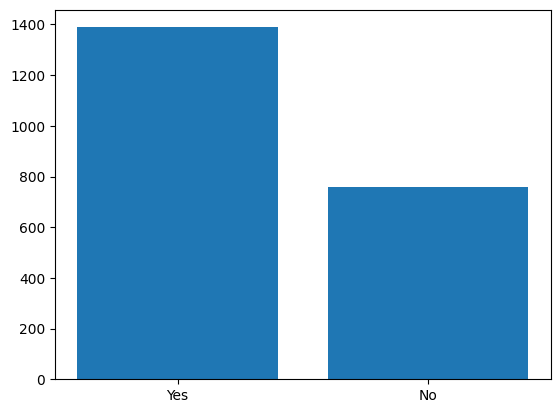

In [7]:
total_diagnosis = dataset.groupby('Diagnosis').count()

plt.bar(["No" if value == 1 else "Yes" for value in total_diagnosis.index], dataset.groupby('Diagnosis')['Diagnosis'].count())
plt.show()



Percentage of Alzheimer by ethnicity:
Caucasian: 36.23%
African American: 32.16%
Asian: 40.78%
Other: 31.75%




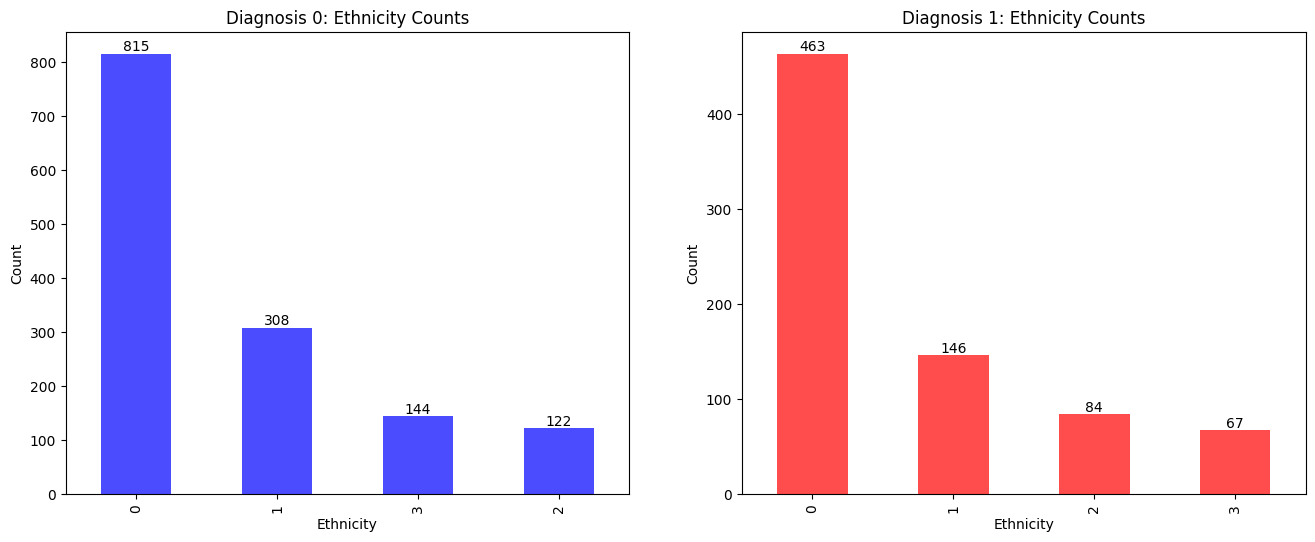

In [8]:
by_ethnicity = dataset.groupby('Diagnosis')['Ethnicity'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
by_ethnicity.loc[0].plot(kind='bar', ax=axs[0], color='b', alpha=0.7)
axs[0].set_title('Diagnosis 0: Ethnicity Counts')
axs[0].set_xlabel('Ethnicity')
axs[0].set_ylabel('Count')
for p in axs[0].patches:
    axs[0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


by_ethnicity.loc[1].plot(kind='bar', ax=axs[1], color='r', alpha=0.7)
axs[1].set_title('Diagnosis 1: Ethnicity Counts')
axs[1].set_xlabel('Ethnicity')
axs[1].set_ylabel('Count')
for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

print(f"""
Percentage of Alzheimer by ethnicity:
Caucasian: {(by_ethnicity.loc[1][0]/(by_ethnicity.loc[0][0] + by_ethnicity.loc[1][0]))*100:.2f}%
African American: {(by_ethnicity.loc[1][1]/(by_ethnicity.loc[0][1] + by_ethnicity.loc[1][1]))*100:.2f}%
Asian: {(by_ethnicity.loc[1][2]/(by_ethnicity.loc[0][2] + by_ethnicity.loc[1][2]))*100:.2f}%
Other: {(by_ethnicity.loc[1][3]/(by_ethnicity.loc[0][3] + by_ethnicity.loc[1][3]))*100:.2f}%

""")

In our dataset, Alzheimer is more prevalent in asian people and lower in ''other'' ethnicity people. However, the close values between them (ranging from 31% to 40%) will probably show as low linearity relationship with the diagnosis feature. We'll investigate further.

In [9]:
def determine_weight_class(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.5:
        return 'Normal'
    elif 24.5 <= bmi < 29.9:
        return '1stDegreeObesity'
    elif 29.9 <= bmi < 39.9:
        return '2ndDegreeObesity'
    else:  # bmi >= 40
        return '3rdDegreeObesity'

dataset['WeightClass'] = dataset['BMI'].apply(determine_weight_class)

This grouping might help we separate the patients by categories that might help us identify alzheimer favorable features.

About lifestyle factors, let's pairplot it to investigate the distribution between diagnosis:

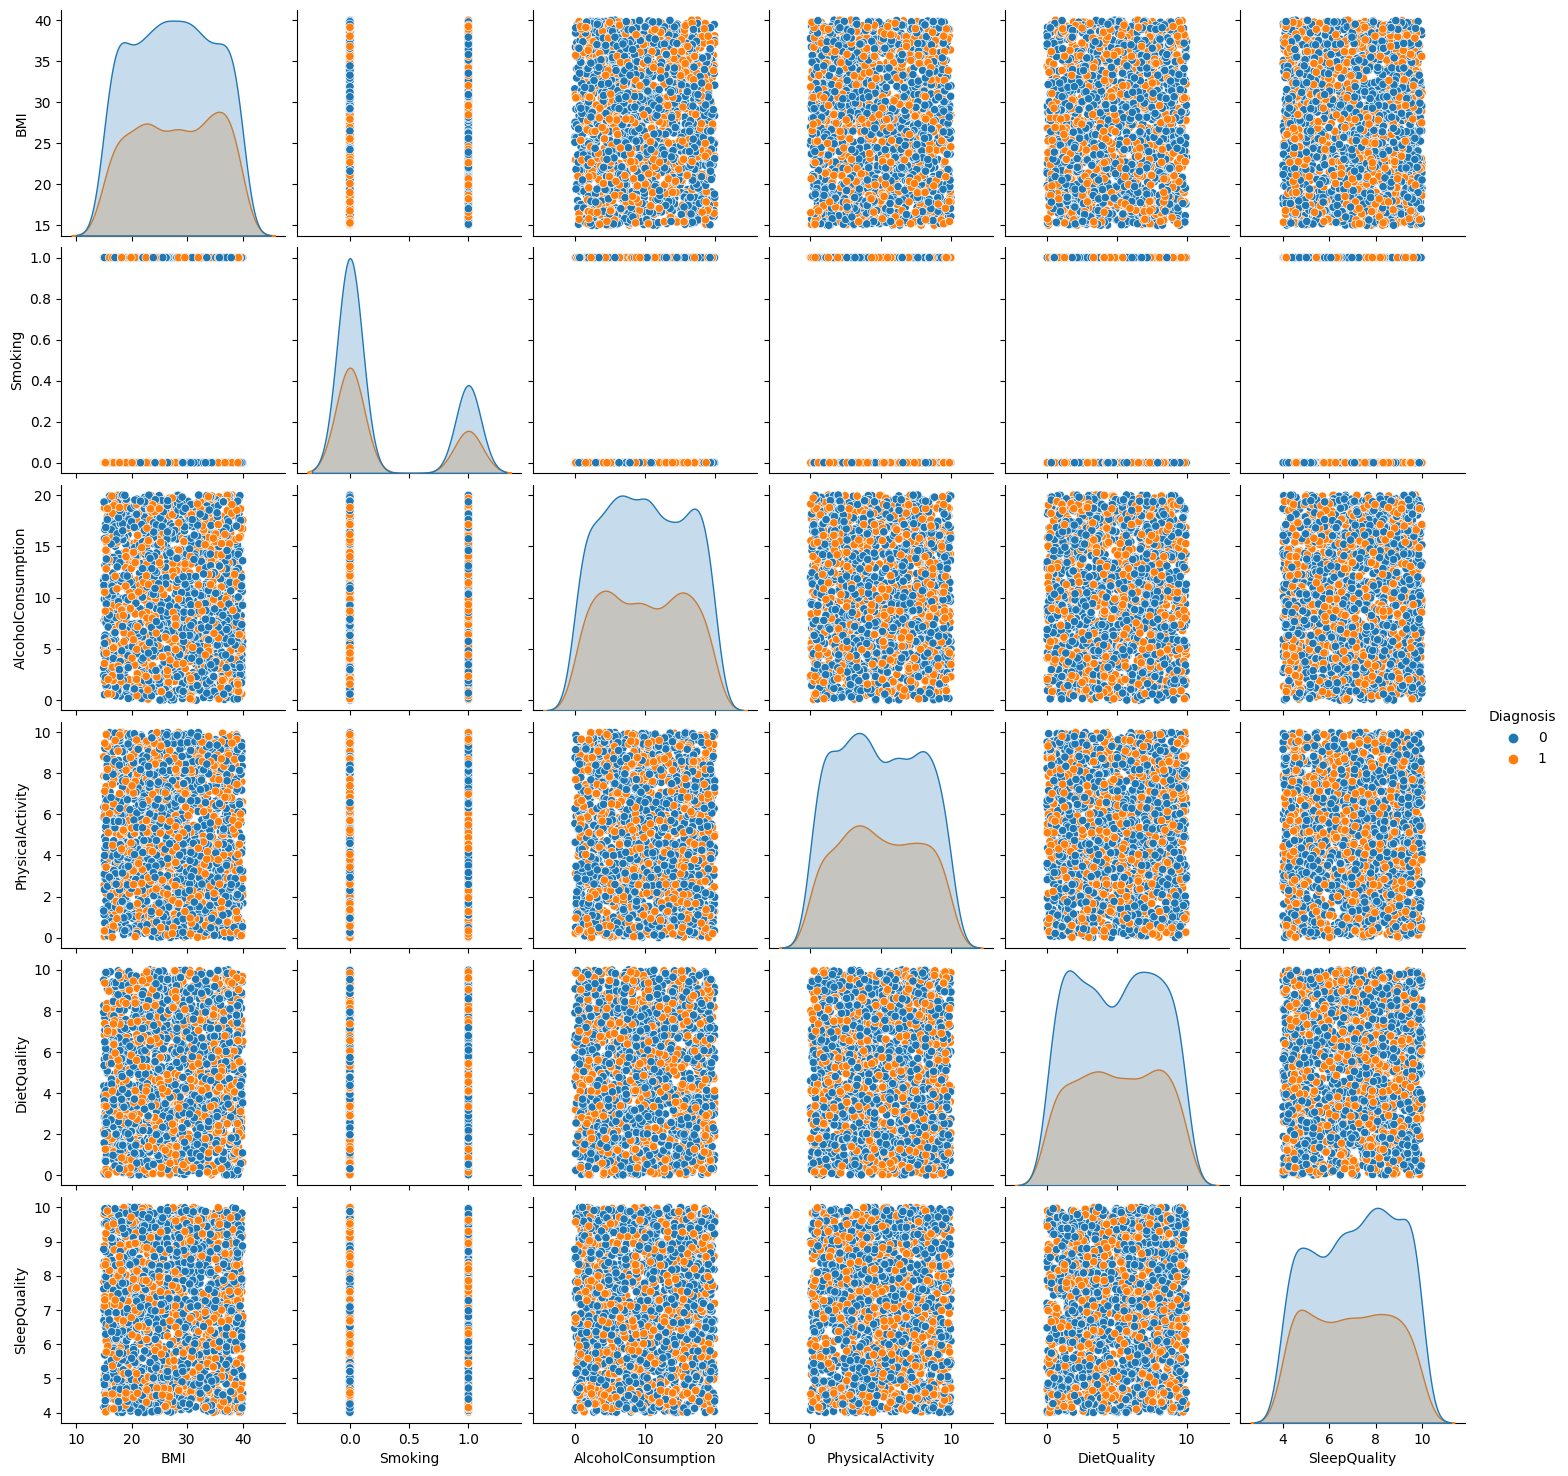

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

lifestyle_cols = ['BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality']

lifestyle_data = dataset[lifestyle_cols + ['Diagnosis']]

sns.pairplot(lifestyle_data, hue='Diagnosis')
plt.show()

A high distribution for lifestyle habits, but some greater than others. Let's check for clinical measures.

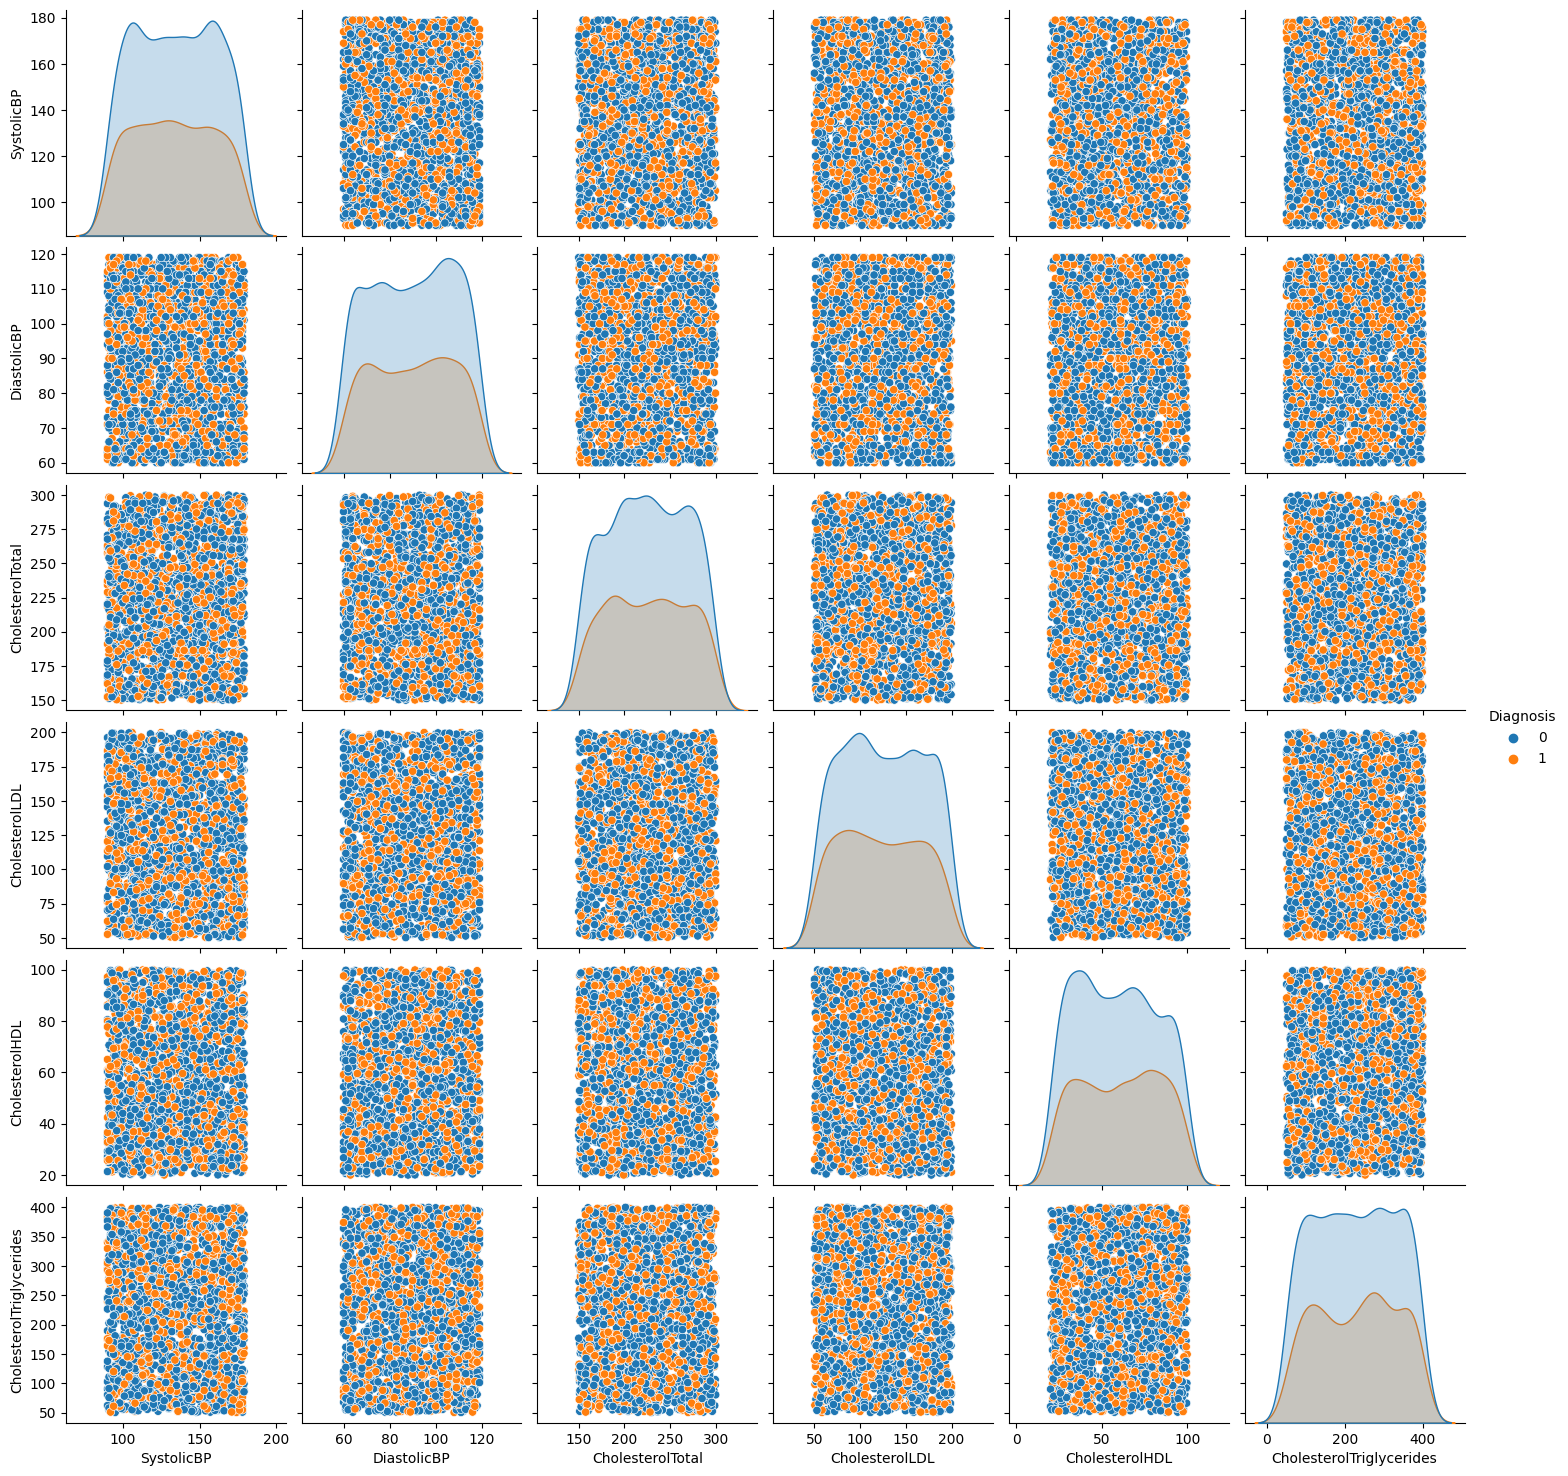

In [11]:
clinical_measures = ['SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides']

clinical_measures_data = dataset[clinical_measures + ['Diagnosis']]

sns.pairplot(clinical_measures_data, hue='Diagnosis')
plt.show()

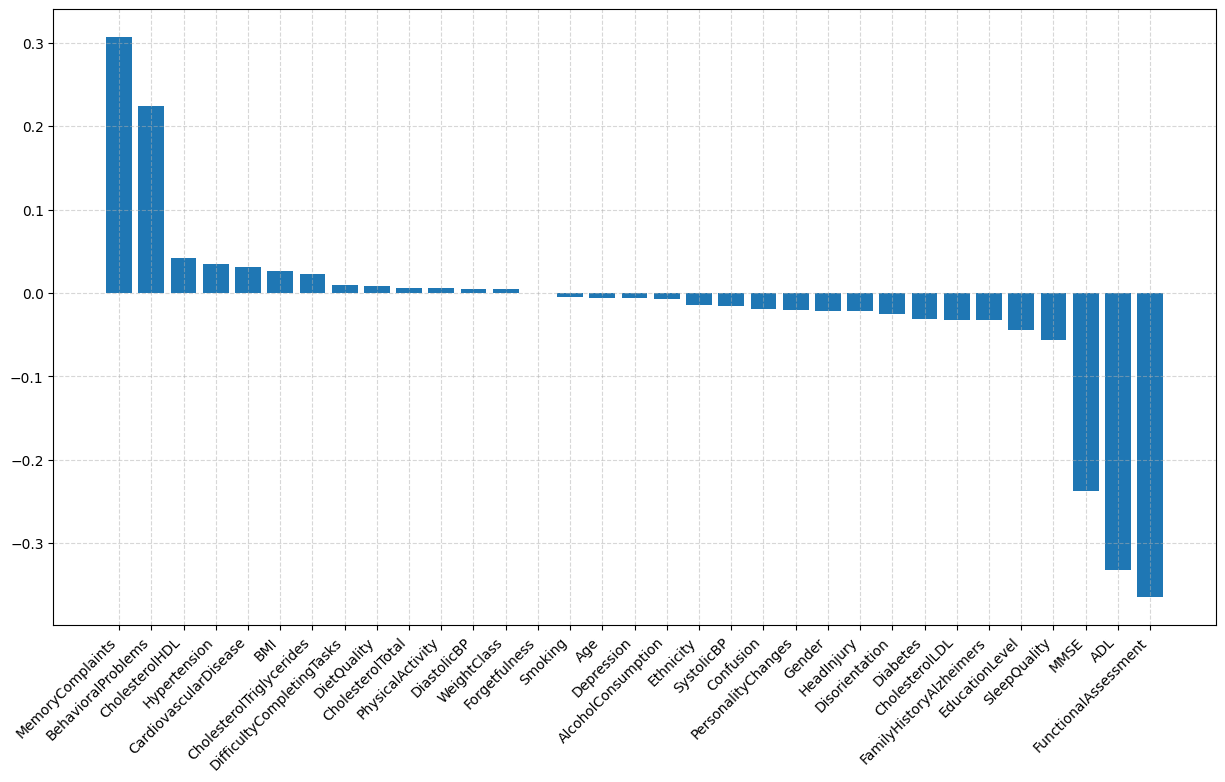

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

data = dataset.drop(columns=['PatientID', 'DoctorInCharge'])
data['WeightClass'] = encoder.fit_transform(data['WeightClass'])

diagnosis_corrmap = data.corr(method = 'pearson')

sorted_correlations_area = diagnosis_corrmap['Diagnosis'].sort_values(ascending=False)[1:]
plt.figure(figsize = (15, 8))
plt.bar(sorted_correlations_area.index, sorted_correlations_area)
plt.grid(linestyle = '--', alpha = 0.5)
plt.xticks(rotation=45, ha='right')
plt.show()

With this correlation map based on the diagnosis column, we can infer(as 0 is negative alzheimer, and 1 is positive for alzheimer): 
Memory Complaints and Behavioral Problems are the two most linearly related features for a positive diagnosis, while Functional Assessment, ADL and MMSE are highly linearly inverse, which means the greater value, the less likely they are to be diagnosed with alzheimer. 


Patients with higher risk to positive Alzheimer's diagnosis: 

* Patients with memory complaints
* Patients with behavorial problems
* Patients with low mini mental score (negative correlation)
* Patients with low ADL score (negative correlation)
* Patients with low functional assessment score (negative correlation)
* Hypertense patients



It's important to take note, however, that this do not define the most important features all the times, as there's relation between diabetes and positive Alzheimer's diagnosis,  as well as age, contrary to the negative correlation in the map that can lead to incorrect interpretations.

In [13]:
data.groupby('Diagnosis')['BehavioralProblems'].value_counts().unstack()

BehavioralProblems     0    1
Diagnosis                    
0                   1255  134
1                    557  203


Memory complaints % for negative diagnosis: 11.59
Memory complaints % for positive diagnosis: 37.63

Behavioral problems % for negative diagnosis: 9.65
Behavioral problems % for positive diagnosis: 26.71



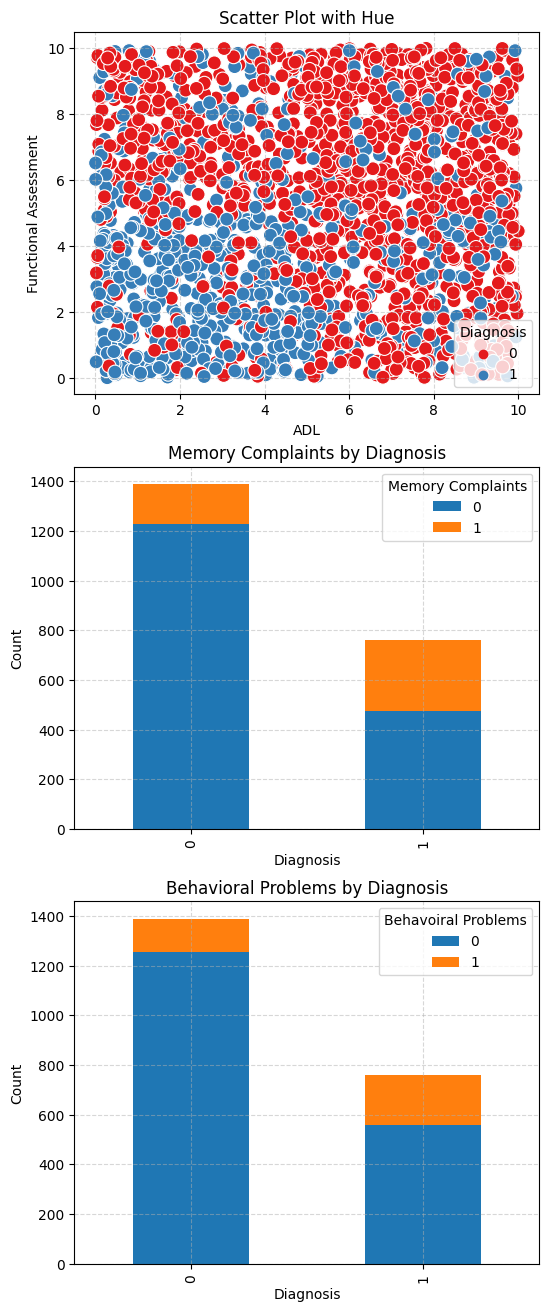

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(6, 16))

sns.scatterplot(x=data['ADL'], y=data['FunctionalAssessment'], hue=data['Diagnosis'], palette='Set1', s=100, ax=axs[0])
axs[0].set_title('Scatter Plot with Hue')
axs[0].set_xlabel('ADL')
axs[0].set_ylabel('Functional Assessment')
axs[0].legend(title='Diagnosis')
axs[0].grid(True, linestyle='--', alpha=0.5)

memory_complaints_counts = data.groupby('Diagnosis')['MemoryComplaints'].value_counts().unstack()
memory_complaints_counts.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Memory Complaints by Diagnosis')
axs[1].set_xlabel('Diagnosis')
axs[1].set_ylabel('Count')
axs[1].legend(title='Memory Complaints')
axs[1].grid(True, linestyle='--', alpha=0.5)

behavioral_problems_counts = data.groupby('Diagnosis')['BehavioralProblems'].value_counts().unstack()
behavioral_problems_counts.plot(kind='bar', stacked=True, ax=axs[2])
axs[2].set_title('Behavioral Problems by Diagnosis')
axs[2].set_xlabel('Diagnosis')
axs[2].set_ylabel('Count')
axs[2].legend(title='Behavoiral Problems')
axs[2].grid(True, linestyle='--', alpha=0.5)

print(f"""
Memory complaints % for negative diagnosis: {memory_complaints_counts[1][0]*100 / (memory_complaints_counts[0][0] + memory_complaints_counts[1][0]):.2f}
Memory complaints % for positive diagnosis: {memory_complaints_counts[1][1]*100 / (memory_complaints_counts[0][1] + memory_complaints_counts[1][1]):.2f}

Behavioral problems % for negative diagnosis: {behavioral_problems_counts[1][0]*100 / (behavioral_problems_counts[0][0] + behavioral_problems_counts[1][0]):.2f}
Behavioral problems % for positive diagnosis: {behavioral_problems_counts[1][1]*100 / (behavioral_problems_counts[0][1] + behavioral_problems_counts[1][1]):.2f}
""")

Those are the most prominent features for classifications, and we can see the grouping discrepance showing: 
* The functional assessment x ADL scatterplot looks like linearly separable
* Memory Complaints, Behavioral Problems x Diagnosis (left negative, right positive) proportional differences are visible.

Let's check the most important features by the algorithm:


In [15]:
X = dataset.drop(columns=['Diagnosis', 'PatientID', 'DoctorInCharge'])  
y = dataset['Diagnosis']

encoder = LabelEncoder()
X['WeightClass'] = encoder.fit_transform(X['WeightClass'])

k_best_features = SelectKBest(score_func=f_classif, k=10)
selector = k_best_features.fit(X, y)
best_features = X.columns[selector.get_support(indices=True)]

dataset[best_features]

EducationLevel  SleepQuality  FamilyHistoryAlzheimers  Hypertension  \
0                  2      9.025679                        0             0   
1                  0      7.151293                        0             0   
2                  1      9.673574                        1             0   
3                  1      8.392554                        0             0   
4                  0      5.597238                        0             0   
...              ...           ...                      ...           ...   
2144               1      7.535540                        0             0   
2145               2      8.555256                        0             0   
2146               1      5.769464                        0             0   
2147               1      8.322874                        0             0   
2148               2      9.878711                        0             0   

      CholesterolHDL       MMSE  FunctionalAssessment  MemoryComplaints  \
0          33.682563  21.463532              6.518877                 0   
1          79.028477  20.613267              7.118696                 0   
2          69.772292   7.356249              5.895077                 0   
3          68.457491  13.991127              8.965106                 0   
4          56.874305  13.517609              6.045039                 0   
...              ...        ...                   ...               ...   
2144       60.943092   1.201190              0.238667                 0   
2145       93.649735   6.458060              8.687480                 0   
2146       99.678209  17.011003              1.972137                 0   
2147       81.281111   4.030491              5.173891                 0   
2148       81.920043  11.114777              6.307543                 0   

      BehavioralProblems       ADL  
0                      0  1.725883  
1                      0  2.592424  
2                      0  7.119548  
3                      1  6.481226  
4                      0  0.014691  
...                  ...       ...  
2144                   0  4.492838  
2145                   1  9.204952  
2146                   0  5.036334  
2147                   0  3.785399  
2148                   1  8.327563  

[2149 rows x 10 columns]

Let's see now how models work with this information. As for the binary classification with plenty linearly unrelated features, we might work well with Random Forest Classifierand SVM: 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)
rf_pred = rf_clf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)

print(f"SVM Accuracy: {svm_acc:.2f}")

print(f"Random Forest Accuracy: {rf_acc:.2f}")




SVM Accuracy: 0.82
Random Forest Accuracy: 0.93


As random forest performed better, we'll take it as the winner for the ''full'' dataset. Let's try with only the best columns now:


In [17]:
X_best = dataset[best_features]
X_best_train, X_best_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.2, random_state = 42)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_best_train, y_train)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_best_train, y_train)

svm_pred = svm_model.predict(X_best_test)
rf_pred = rf_clf.predict(X_best_test)

rf_acc = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)

print(f"SVM Accuracy: {svm_acc:.2f}")

print(f"Random Forest Accuracy: {rf_acc:.2f}")

SVM Accuracy: 0.83
Random Forest Accuracy: 0.95


Our models performed better without many of the columns, but not a huge increase. This might mean that other columns are either unimportant, or unimportant columns disguised as ''best features'' are still holding the model down, or other data processing is needed. Let's check how a neural model deals:


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,241 (2.24 MB)

 Trainable params: 586,241 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
train_history = model.fit(X_train, y_train,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5485 - loss: 1.3199 - val_accuracy: 0.6192 - val_loss: 0.6698
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6016 - loss: 0.6811 - val_accuracy: 0.6250 - val_loss: 0.6708
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6426 - loss: 0.6659 - val_accuracy: 0.6192 - val_loss: 0.6651
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6383 - loss: 0.6601 - val_accuracy: 0.6192 - val_loss: 0.6659
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6386 - loss: 0.6586 - val_accuracy: 0.6192 - val_loss: 0.6621
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6473 - loss: 0.6422 - val_accuracy: 0.6192 - val_loss: 0.6632
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6582 - loss: 0.6311 - val_accuracy: 0.6250 - val_loss: 0.6383
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6455 - loss: 0.6320 - val_accuracy: 0.6221 

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8208 - loss: 0.4456 
Test Accuracy: 81.40%


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


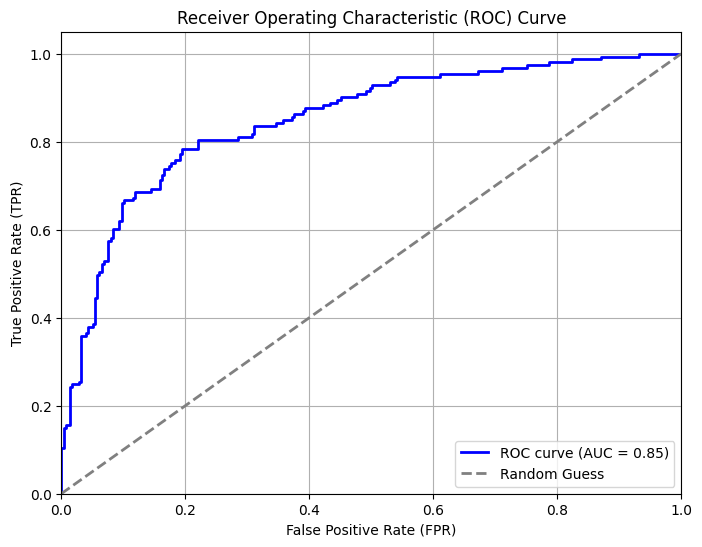

In [21]:
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [22]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
report = classification_report(y_test, y_pred)
print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       277
           1       0.78      0.66      0.72       153

    accuracy                           0.81       430
   macro avg       0.81      0.78      0.79       430
weighted avg       0.81      0.81      0.81       430



A good performance! About 80% for F1-Score and accuracy. We can try and see the model performance working with the important features only. 

In [23]:
X_best_train, X_best_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.2, random_state = 42)

model = Sequential()
model.add(Dense(512, input_dim=X_best_train.shape[1], activation='relu'))
model.add(Dense(512, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,465 (2.19 MB)

 Trainable params: 574,465 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
train_history = model.fit(X_best_train, y_train,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6460 - loss: 0.6798 - val_accuracy: 0.6570 - val_loss: 0.6064
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7389 - loss: 0.5385 - val_accuracy: 0.7297 - val_loss: 0.5496
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7794 - loss: 0.4767 - val_accuracy: 0.7035 - val_loss: 0.6085
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7715 - loss: 0.4908 - val_accuracy: 0.7762 - val_loss: 0.5060
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7975 - loss: 0.4523 - val_accuracy: 0.7471 - val_loss: 0.4828
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8280 - loss: 0.4026 - val_accuracy: 0.6686 - val_loss: 0.5426
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8103 - loss: 0.4616 - val_accuracy: 0.7907 - val_loss: 0.4405
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8297 - loss: 0.4220 - val_accuracy: 0.7180 -

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


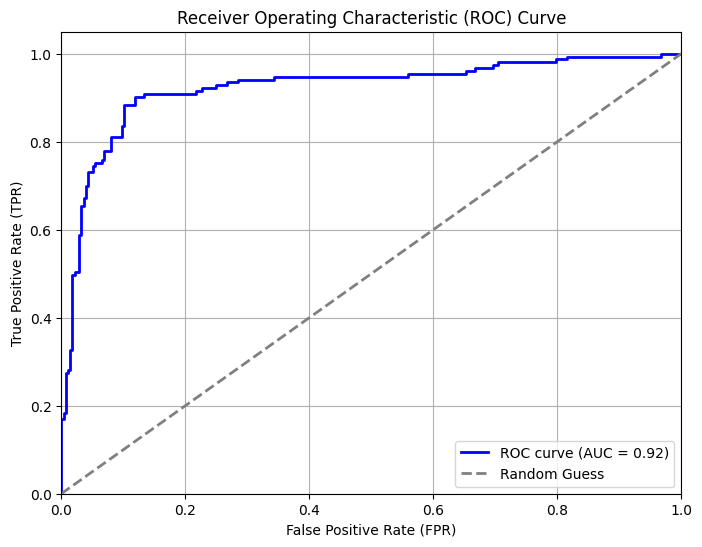

In [25]:
y_pred_proba = model.predict(X_best_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [26]:
y_pred = model.predict(X_best_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
report = classification_report(y_test, y_pred)
print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       277
           1       0.86      0.76      0.81       153

    accuracy                           0.87       430
   macro avg       0.87      0.85      0.86       430
weighted avg       0.87      0.87      0.87       430



Wow, even better now! The linearly related features made the neurons perform way better. 